# Pop atoms
Let's find the musical atoms that make up the most popular hits of the last decades

## Import functions and libraries

In [4]:
from functions import *
from os.path import exists
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Get data

We want to compare the audio features of the most popular songs of before 1962 (before the Beatles era), with a more general sample of popular songs from the 60's to current time. 

### Popular according to Billboard

In [6]:
# Get all the Billboard data.
# Billboard collects the most popular songs weekly since 1958. This is the data we will use for this project.
# The API may fail, so to avoid having to repeat queries, we save the data continuously int a csv.

recalculate = True

if recalculate:
        
    df_raw_billboard = create_weekly_ranks_df("1980-01-02", "1990-01-01", csv_file = "data/0_raw_billboard.csv", step=7)

HTTPError: 403 Client Error: Forbidden for url: https://www.billboard.com/charts/hot-100/1990-01-01

In [3]:
# Get peak values. 
# Some songs are listed more than once, as they come up several times in the charts for different weeks. 
# We will only keep one entry for each song, calculate the peak position, maximum number of weeks on the chart, and date that peak position was reached for each song.  

recalculate = True

if recalculate:

#   Load the billboard ranks data
    df_raw_billboard = pd.read_csv("data/0_raw_billboard.csv")

    #calculate rank peak values
    df_hits_billboard = calculate_ranks_peaks(df_raw_billboard)

    #calculate peak year
    df_hits_billboard["peak_year"] = df_hits_billboard["date"].str[:4].astype(int)

    # Save the cleaned data to a CSV file.
    df_hits_billboard.to_csv("data/1_hits_billboard.csv", index=False)

In [ ]:
## Get audio analysis data from Spotify.
# ! Beware: DO NOT re-execute this query unless you absolutely have to. Spotify may block your API key for a while.  

if not exists("data/2_audio_analysis_billboard.csv"):

    # Load the cleaned data
    df_hits_billboard = pd.read_csv("data/1_hits_billboard.csv")

    # add audio analysis columns
    audio_analysis_df = create_audio_analysis_df(df_hits_billboard)

    # Save the cleaned data to a CSV file.
    audio_analysis_df.to_csv("data/2_audio_analysis_billboard.csv", index=False)

### Popular of all time

In [2]:
# We asked GPT for a list of songs that represent the greatest hits from year to year since 1960. 
# The result was stored in a csv file "df_songs_sample.csv"

df_songs_sample = pd.read_csv("data/1_hits_sample.csv")

# we need to melt the dataframe to have one column for years, one column for titles, and one column for the artist name. 
df_songs_sample = df_songs_sample.melt(var_name='peak_year', value_name='title')
df_songs_sample["artist"] = df_songs_sample["title"].str.split(" - ").str[0]
df_songs_sample["title"] = df_songs_sample["title"].str.split(" - ").str[1]

In [3]:
# We can now query these songs from spotify. 
# ! Beware: DO NOT re-execute this query unless you absolutely have to. Spotify may block your API key for a while.  

if not exists("data/2_audio_analysis_sample.csv"):
    df_audio_analysis_sample = create_audio_analysis_df(df_songs_sample)

    # Save the cleaned data to a CSV file.
    df_audio_analysis_sample.to_csv("data/2_audio_analysis_sample.csv", index=False)

## Clean data

### Popular before The Beatles

In [71]:
# read data from csvs
aax_60 = pd.read_csv("data/2_audio_analysis_billboard.csv")
aax_sample = pd.read_csv("data/2_audio_analysis_sample.csv")

In [72]:
# Let's explore the 58-60s data
aax_60.duplicated(subset=['title', 'artist']).sum()
aax_60.info()

# in the data from the years before 1960, there are no null values. 
# All the data types seem correct.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             819 non-null    object 
 1   artist            819 non-null    object 
 2   weeks             819 non-null    float64
 3   peak_rank         819 non-null    float64
 4   peak_date         819 non-null    object 
 5   id                819 non-null    object 
 6   title_spotify     819 non-null    object 
 7   album             819 non-null    object 
 8   sp_popularity     819 non-null    float64
 9   colab             819 non-null    object 
 10  release_date      819 non-null    object 
 11  danceability      819 non-null    float64
 12  energy            819 non-null    float64
 13  loudness          819 non-null    float64
 14  speechiness       819 non-null    float64
 15  acousticness      819 non-null    float64
 16  instrumentalness  819 non-null    float64
 1

### Popular of all time. 

In [73]:
# Let's explore the sample data

aax_sample.duplicated(subset=['title', 'artist']).sum()
aax_sample.loc[aax_sample.duplicated(subset=['title', 'artist'], keep=False), ['title_spotify', 'title', 'peak_year', 'artist']].sort_values(by=['title', 'artist'])
# there are 6 repeated values in the sample data. Most of them look ok (some songs can reach a popularity peak in multiple years).
# But there's one particular data point that looks  mistaken: the song "I Will Always Love You" by Whitney Houston wasn't released in 1975. 


,title_spotify,title,peak_year,artist
77,I Will Always Love You,I Will Always Love You,1975,Whitney Houston
166,I Will Always Love You,I Will Always Love You,1993,Whitney Houston
306,Save Your Tears,Save Your Tears,2021,The Weeknd
322,Save Your Tears,Save Your Tears,2024,The Weeknd
158,Shoop,Shoop,1991,Salt-N-Pepa
174,Shoop,Shoop,1994,Salt-N-Pepa
2,The Twist,The Twist,1960,Chubby Checker
10,The Twist,The Twist,1962,Chubby Checker
3,"The Theme from ""A Summer Place""",Theme from A Summer Place,1960,Percy Faith & His Orchestra
6,"The Theme from ""A Summer Place""",Theme from A Summer Place,1961,Percy Faith & His Orchestra


In [74]:

# We will remove the mistaken value and filter the first peak date for the rest of duplicates.
aax_sample = aax_sample[~((aax_sample.title=="I Will Always Love You") & (aax_sample.peak_year==1975))]
aax_sample.drop_duplicates(subset=['title', 'artist'], keep='first', inplace=True)

aax_sample.duplicated(subset=['title', 'artist']).sum() #there are no more duplicates

np.int64(0)

## Combine datasets: 

In [75]:
# We want to make sure that the datasets are comparable and use the same column names. 

print(aax_sample.columns)
print(aax_60.columns)

Index(['title_spotify', 'album', 'sp_popularity', 'artist', 'colab',
       'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration', 'peak_year', 'title'],
      dtype='object')
Index(['title', 'artist', 'weeks', 'peak_rank', 'peak_date', 'id',
       'title_spotify', 'album', 'sp_popularity', 'colab', 'release_date',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'key', 'mode', 'tempo',
       'duration'],
      dtype='object')


In [76]:
# We will:

# * sort the columns to make df easier to compare and humanly readable: 
aax_sample = aax_sample.reindex(['title', 'title_spotify','artist', 'album', 'colab', 
                           'release_date', 'peak_year', 'lustrum', 'sp_popularity', 
                           'tempo', 'duration','key',  'mode', 
                           'danceability', 'energy', 'loudness','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence'], axis = 1)

aax_60 = aax_60.reindex(['title', 'title_spotify', 'artist', 'album', 'colab', 'id', 
                       'release_date', 'peak_rank', 'peak_date', 'peak_year', 'lustrum', 'weeks', 'sp_popularity', 
                       'tempo', 'duration', 'key', 'mode', 
                       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence'], axis = 1)


In [77]:
## We can now combine de df: 
aax_combined = pd.concat([aax_60, aax_sample], ignore_index=True)

In [78]:
# Calculate the release year: 
aax_combined["release_year"] = aax_combined["release_date"].str[:4].astype(int)

# And the peak year: 
aax_combined["peak_year"] = aax_combined["peak_year"].fillna(aax_combined['peak_date'].str[:4].astype(float))


In [79]:
# * add a column to check if the song was popular before 1964:
aax_combined["before_1964"] = aax_combined["peak_year"] < 1964

# * add "lustrum_year" to group songs by lustrum later in the analysis:
aax_combined['lustrum'] = (aax_combined['peak_year'] // 5 * 5).astype(str) + '-' + ((aax_combined['peak_year'] // 5 * 5) + 4).astype(str)

In [80]:
# write a new csv with the combined data
aax_combined.to_csv("data/aax_combined.csv", index=False)

## Explore data

Let's start by analysis the relation between different parameters:


In [83]:
# load the combined df
aax_combined = pd.read_csv("data/aax_combined.csv")

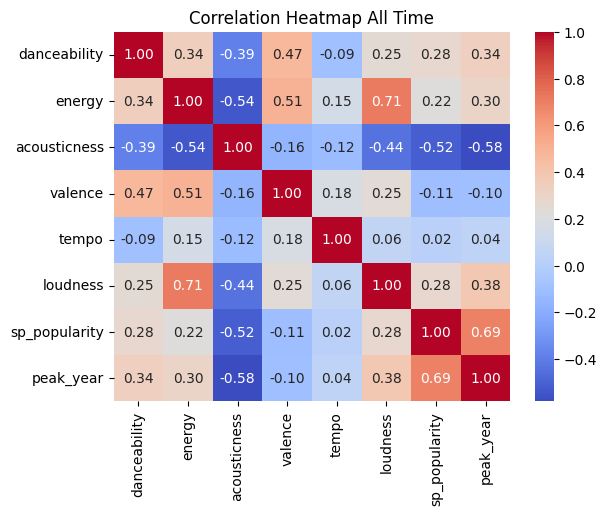

In [85]:
# Calcular la matriz de correlación
corr = aax_combined[['danceability', 'energy', 'acousticness', 'valence', 'tempo', 'loudness','sp_popularity', 'peak_year']].corr()
# Crear el heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap All Time')
plt.show()

There seems to be a relation between time and other parameters. Let's drill in. 

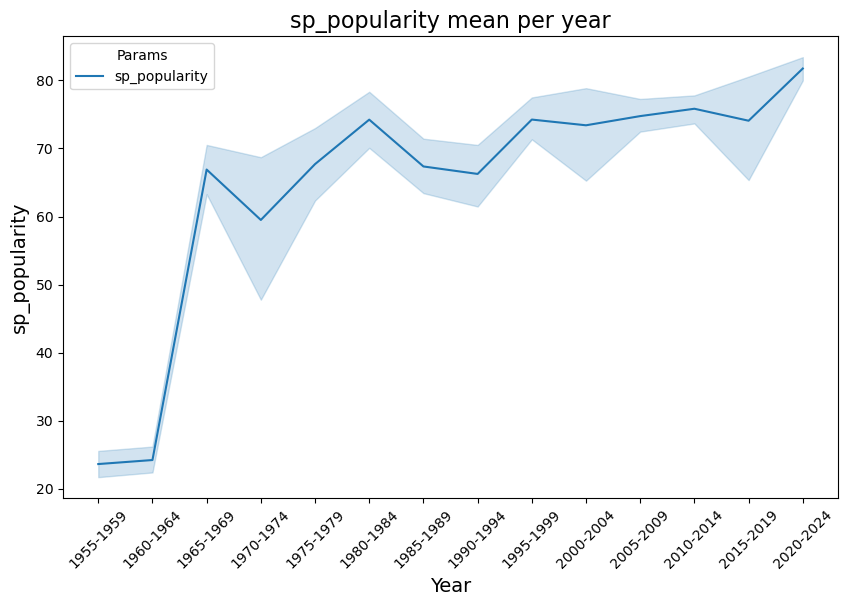

In [15]:
# Plot line charts of popularity: 

plot_year_mean(aax_combined, type="line", params=['sp_popularity'], year_column='lustrum',grid=False)


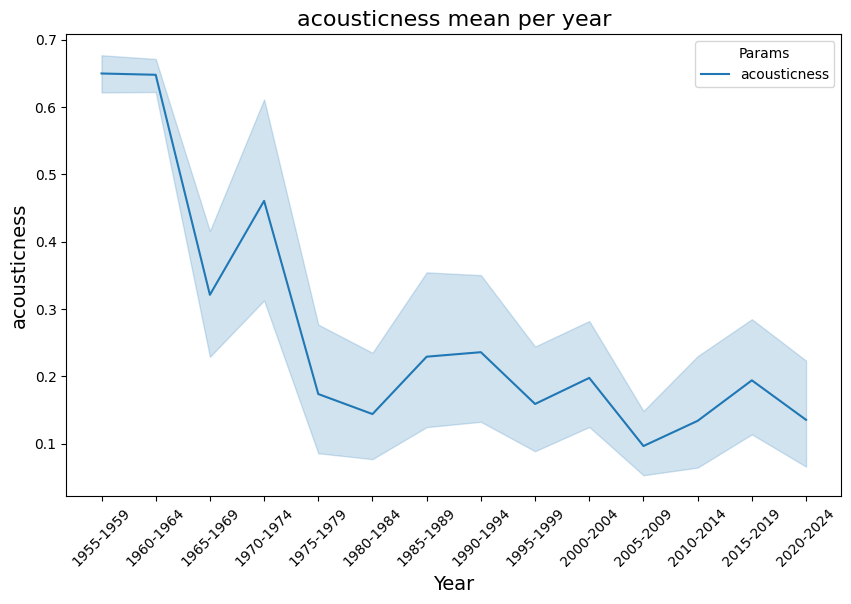

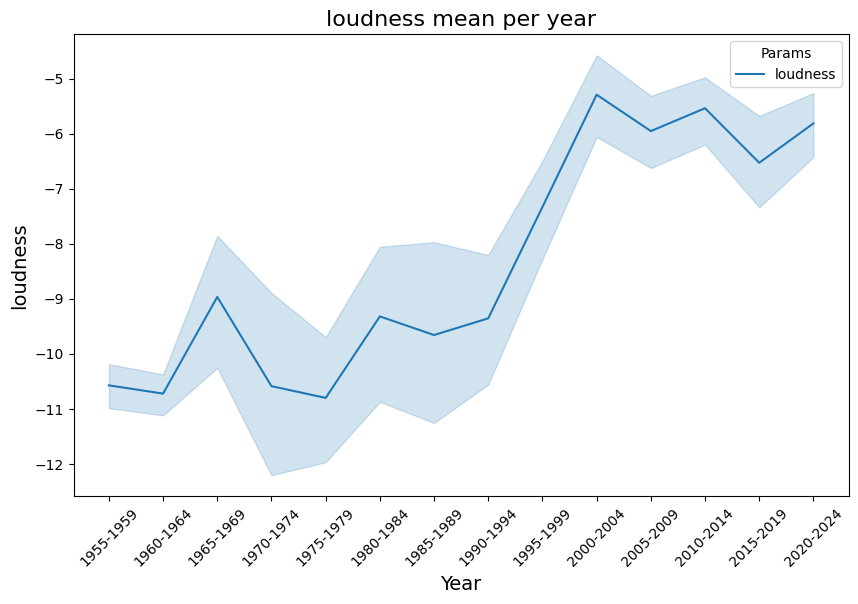

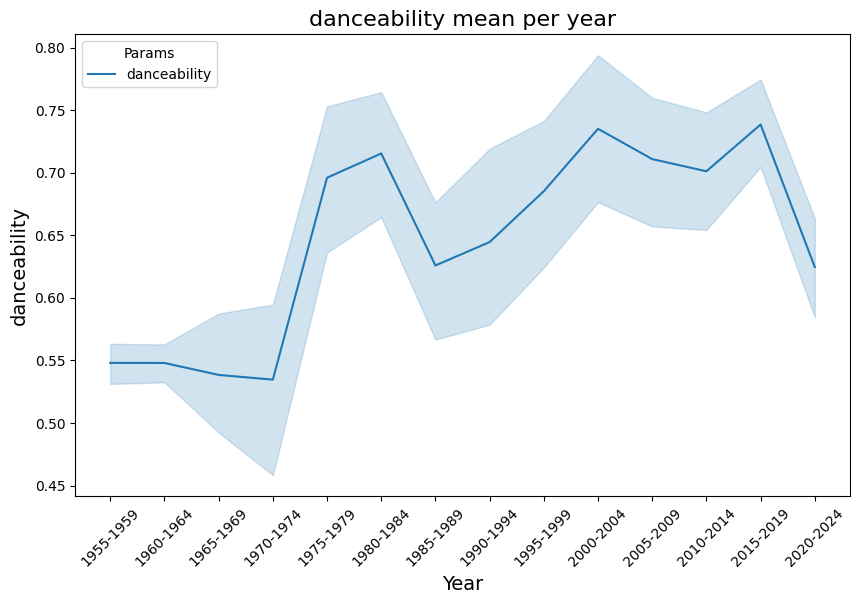

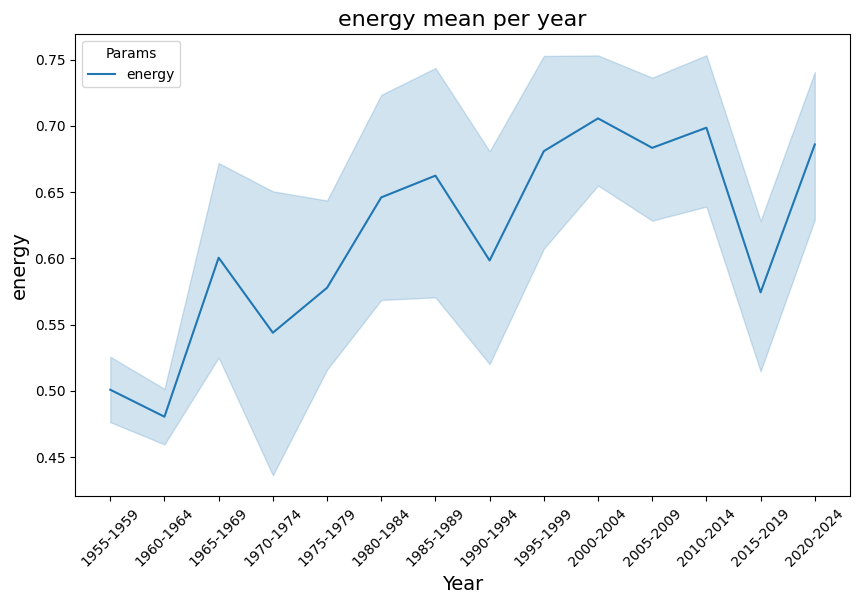

In [3]:

# Plot line charts of different acoustic parameters:
plot_year_mean(aax_combined, type="line", params=['acousticness'], year_column='lustrum',grid=False)
plot_year_mean(aax_combined, type="line", params=['loudness'], year_column='lustrum',grid=False)
plot_year_mean(aax_combined, type="line", params=['danceability'], year_column='lustrum',grid=False)
plot_year_mean(aax_combined, type="line", params=['energy'], year_column='lustrum',grid=False)

Did it take longer to reach fame in the past?

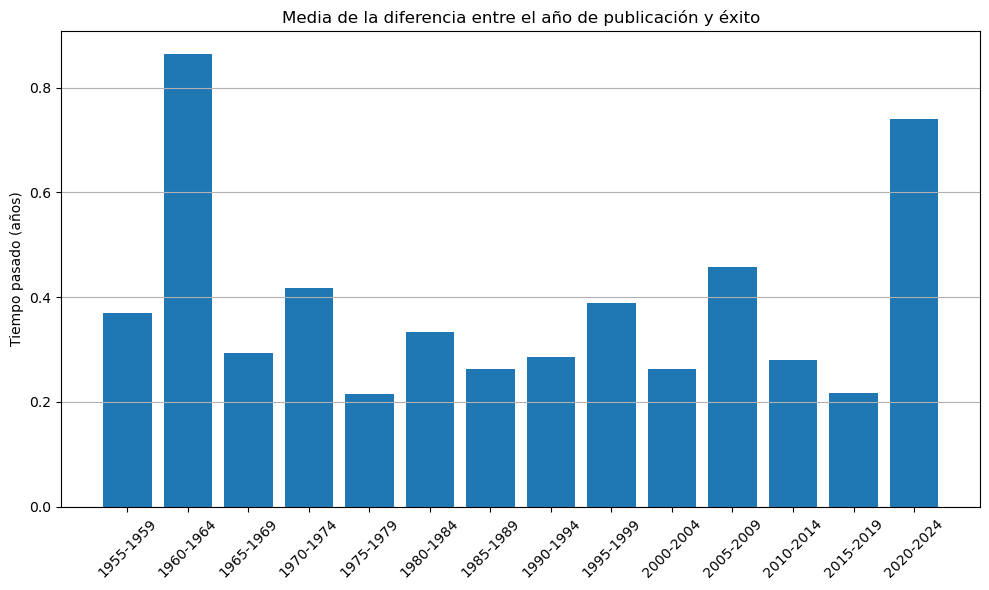

In [26]:
# Calculate the mean difference between peak date and release date:

aax_combined['difference'] = np.where(aax_combined['peak_year'] >= aax_combined['release_year'],
                                     aax_combined['peak_year'] - aax_combined['release_year'],
                                     np.nan)

# group by lumstrum and calculate the mean:
mean_difference = aax_combined.groupby('lustrum')['difference'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(mean_difference['lustrum'], mean_difference['difference'])
plt.xlabel('')
plt.ylabel('Tiempo pasado (años)')
plt.title('Media de la diferencia entre el año de publicación y éxito')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Conclussions: 

### The Beatles invented popularity

We can observe some general trends that differentiate the music before and after the Beatles era. But if we had to pick only one headline, this would be it: 

"The Beatles invented popularity"

Or popularity invented the Beatles, more probably. This is the time when color TV sets gained adoption the mass media was really born. 

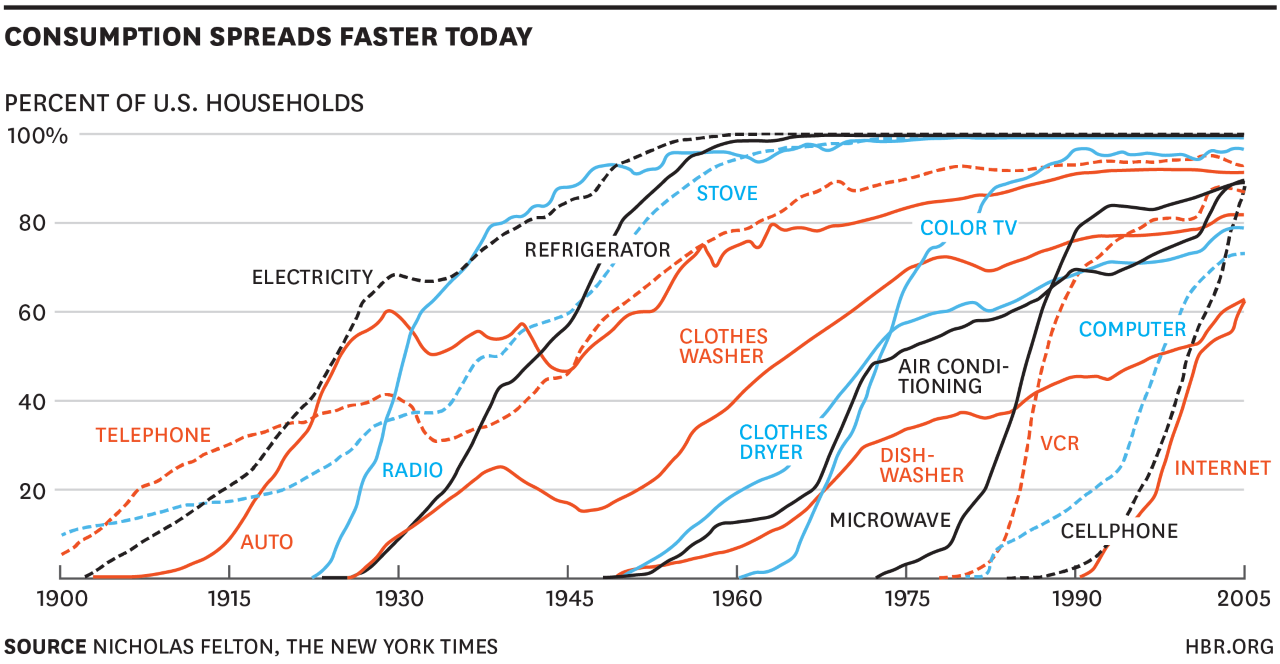

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


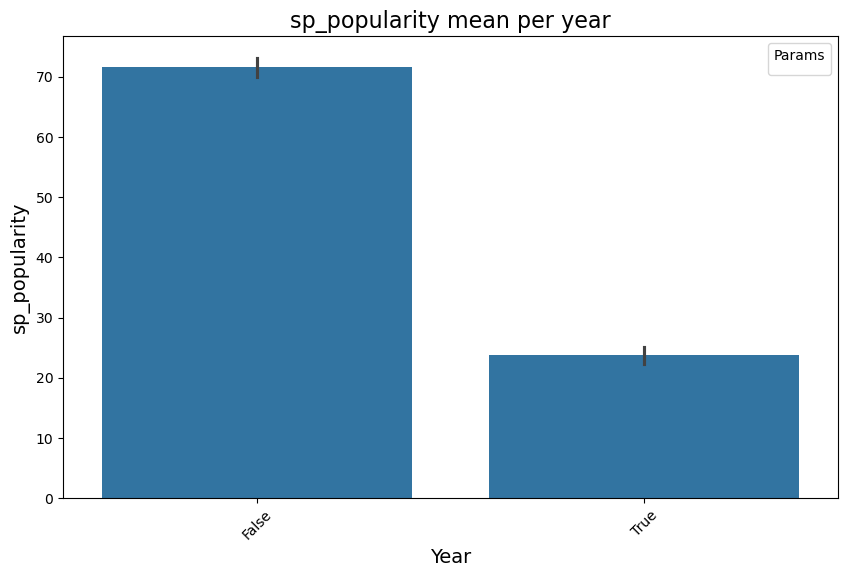

In [17]:
# Plot bar chart of popularity before 1964 (true of false):
plot_year_mean(aax_combined, type="bar", params=['sp_popularity'], year_column='before_1964',figsize=(10,6),grid=False)

There's a huge difference in popularity before the songs before and after that time. This could also be explained due to some data bias, and we will leave this for future analysis. 

### Music is becoming more synthetic 

The other major change has to do with acousticness. Songs become more synthetic after this era and this is clear in the charts. 

/Users/almu/Code/ironhack_projects/w3-popatoms/functions.py:261: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Params")


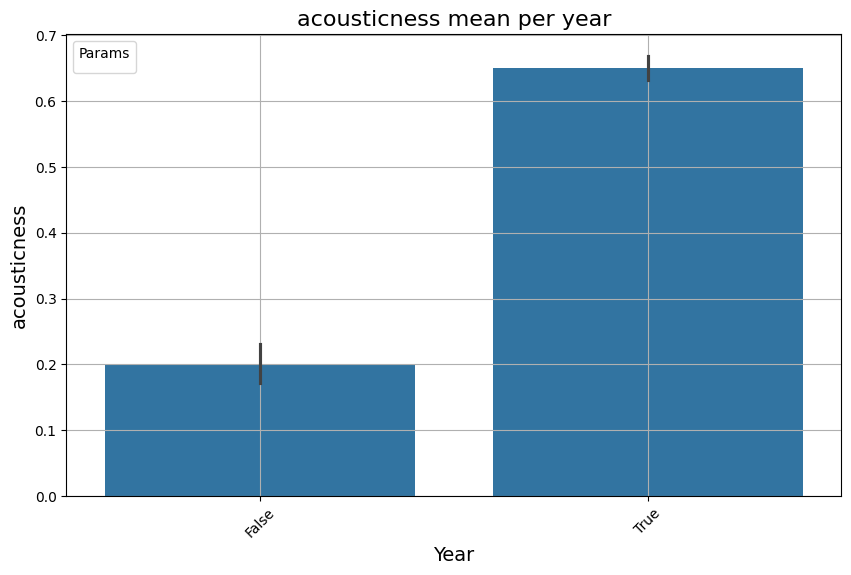

In [7]:
# Plot line charts of different acoustic parameters:
plot_year_mean(aax_combined, type="bar", params=['acousticness'], year_column='before_1964')


### Music is becoming louder

/Users/almu/Code/ironhack/projects/w3-popatoms/functions.py:260: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Params")


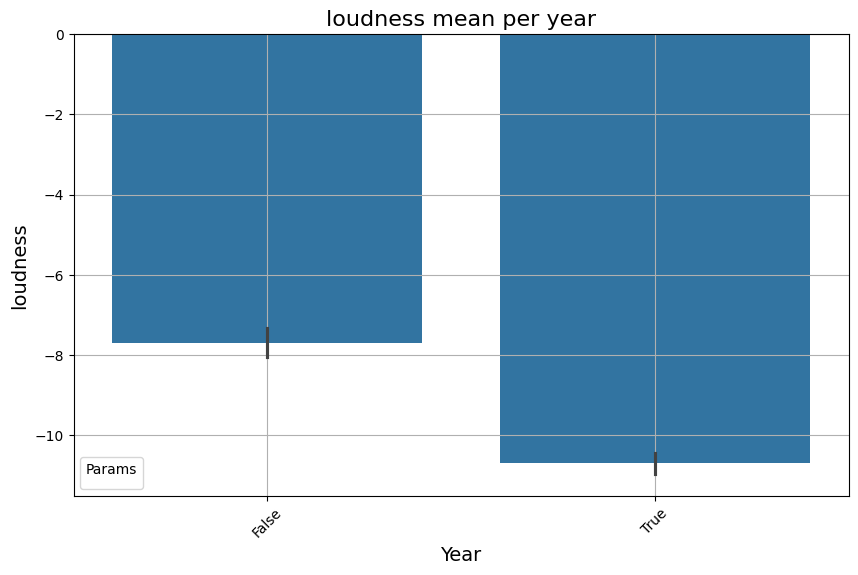

In [15]:
# Plot line charts of different acoustic parameters:
plot_year_mean(aax_combined, type="bar", params=['loudness'], year_column='before_1964')